In [1]:
# cassion is used for AstraDB
!pip install langchain langgraph langchain_groq langchain_community cassio

In [ ]:
!pip install langchain_huggingface chromadb langchainhub tiktoken wikipedia

In [2]:
import cassio
from google.colab import userdata

# Connection to the AstraDB
ASTRA_DB_APPLICATION_TOKEN = userdata.get("ASTRA_DB_TOKEN")
ASTRA_DB_ID = userdata.get("ASTRA_DB_ID")
cassio.init(token = ASTRA_DB_APPLICATION_TOKEN, database_id = ASTRA_DB_ID)

In [9]:
# Build index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import WebBaseLoader

# Docs to index
urls = [
    "https://www.promptingguide.ai/research/rag",
    "https://www.promptingguide.ai/",
    "https://www.promptingguide.ai/techniques/fewshot",
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = text_splitter.split_documents(doc_list)

In [14]:
docs_split[0]

Document(metadata={'source': 'https://www.promptingguide.ai/research/rag', 'title': 'Retrieval Augmented Generation (RAG) for LLMs | Prompt Engineering Guide ', 'language': 'en'}, page_content="Retrieval Augmented Generation (RAG) for LLMs | Prompt Engineering Guide Prompt Engineering GuideðŸŽ“ Prompt Engineering CourseðŸŽ“ Prompt Engineering CourseServicesServicesAboutAboutGitHubGitHub (opens in a new tab)DiscordDiscord (opens in a new tab)Prompt EngineeringIntroductionLLM SettingsBasics of PromptingPrompt ElementsGeneral Tips for Designing PromptsExamples of PromptsTechniquesZero-shot PromptingFew-shot PromptingChain-of-Thought PromptingMeta PromptingSelf-ConsistencyGenerate Knowledge PromptingPrompt ChainingTree of ThoughtsRetrieval Augmented GenerationAutomatic Reasoning and Tool-useAutomatic Prompt EngineerActive-PromptDirectional Stimulus PromptingProgram-Aided Language ModelsReActReflexionMultimodal CoTGraph PromptingGuidesOptimizing PromptsApplicationsFine-tuning GPT-4oFunction

In [15]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(
    embedding = embeddings,
    table_name = "qa_mini_demo",
    session = None,
    keyspace = None
)

In [19]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)
print("Inserted %i headlines" % len(docs_split))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 121 headlines


In [24]:
retriever = astra_vector_store.as_retriever()
response = retriever.invoke("What is agent?")

print("Length of similar documents : ", len(response))
print()
print(response)

Length of similar documents :  4

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for planni

In [27]:
# LangGraph application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [28]:
# Data model
class RouteQuery(BaseModel):
  """Route the user query to the most relevant data source"""
  datasource : Literal["vectorstore", "wiki_search"] = Field(
      ...,
      description = "Given a user question, route is used to choose to route it to Wikipedia or vectorstore."
  )

In [30]:
from langchain_groq import ChatGroq

groq_api_key = userdata.get("GROQ_API_KEY")
llm = ChatGroq(groq_api_key = groq_api_key, model = "Llama-3.1-70b-Versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f2c11588910>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f2c11589600>, model_name='Llama-3.1-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [31]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [32]:
# Prompt
system = """You are an expert at routing user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attack.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router

In [33]:
print(question_router.invoke(
    {
        "question" : "What is agent?"
    }
))

datasource='vectorstore'


In [34]:
print(question_router.invoke(
    {
        "question" : "What is Lim Guan Eng?"
    }
))

datasource='wiki_search'


In [37]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
wiki_wrapper = WikipediaAPIWrapper(top_k_results = 1, doc_content_chars_max = 1000)
wiki = WikipediaQueryRun(api_wrapper = wiki_wrapper)

In [38]:
wiki.run("Tell me about Ronaldo")

"Page: Cristiano Ronaldo\nSummary: Cristiano Ronaldo dos Santos Aveiro  (Portuguese pronunciation: [kɾiʃˈtjɐnu ʁɔˈnaldu]; born 5 February 1985) is a Portuguese professional footballer who plays as a forward for and captains both Saudi Pro League club Al Nassr and the Portugal national team. Widely regarded as one of the greatest players of all time, Ronaldo has won five Ballon d'Or awards, a record three UEFA Men's Player of the Year Awards, and four European Golden Shoes, the most by a European player. He has won 33 trophies in his career, including seven league titles, five UEFA Champions Leagues, the UEFA European Championship and the UEFA Nations League. Ronaldo holds the records for most appearances (183), goals (140) and assists (42) in the Champions League, most appearances (30), assists (8), goals in the European Championship (14), international goals (132) and international appearances (214). He is one of the few players to have made over 1,200 professional career appearances,

In [39]:
# AI Agent Application using LangGraph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of graph
  Attributes:
    question: question
    generation: LLM generation
    documents: list of documents
  """
  question : str
  generation : str
  documents : List[str]

In [56]:
from langchain.schema import Document

def retrieve(state):
  """
  Retrieve documents

  Args
    state (dict): The current graph state
  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents
  """
  print("---Vector Store---")
  question = state["question"]

  # Retrieval]
  documents = retriever.invoke(question)
  return {"documents":documents, "question" : question}

In [42]:
def wiki_search(state):
  """
  Retrieve info from Wikipedia

  Args
    state (dict): The current graph state
  Returns:
    state (dict): Updates documents key with appeded web results
  """
  print("---Wikipedia---")

  question = state["question"]

  # Wiki search
  docs = wiki.invoke({"query" : question})

  wiki_results = docs

  wiki_results = Document(page_content=wiki_results)

  return {"documents" : wiki_results, "question" : question}

In [44]:
### Edges ###
def route_question(state):
  """
  Route question to wiki search or RAG

  Args:
    state (dict): The current graph state

  Returns:
    str: Next node to call
  """
  print("ROUTE QUESTION---")
  question = state["question"]
  source = question_router.invoke({"question":question})

  if source.datasource == "wiki_search":
    print("---ROUTE QUESTION TO WIKI-SEARCH---")
    return "wiki_search"
  else:
    print("---ROUTE QUESTION TO VECTORSTORE---")
    return "vectorstore"

In [57]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)

# Build the graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search" : "wiki_search",
        "vectorstore" : "retrieve"
    }
)

workflow.add_edge(
    "retrieve",
    END
)

workflow.add_edge(
    "wiki_search",
    END
)

# Compile
app = workflow.compile()

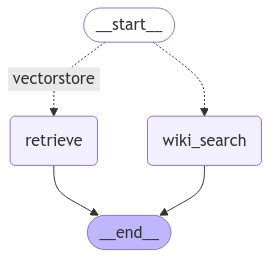

In [58]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [71]:
from pprint import pprint

# Run
inputs = {
    "question" : "What is agent?"
}

for output in app.stream(inputs):
    for key, value in output.items():
      # Node
      pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

ROUTE QUESTION---


---ROUTE QUESTION TO VECTORSTORE---
---Vector Store---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


In [75]:
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)

ROUTE QUESTION---
---ROUTE QUESTION TO WIKI-SEARCH---
---Wikipedia---
"Node 'wiki_search':"
'\n---\n'
('Page: The Avengers (2012 film)\n'
 "Summary: Marvel's The Avengers (titled Marvel Avengers Assemble in the "
 'United Kingdom and Ireland and commonly referred to as simply The Avengers) '
 'is a 2012 American superhero film based on the Marvel Comics superhero team '
 'of the same name. Produced by Marvel Studios and distributed by Walt Disney '
 'Studios Motion Pictures, it is the sixth film in the Marvel Cinematic '
 'Universe (MCU). Written and directed by Joss Whedon, the film features an '
 'ensemble cast including Robert Downey Jr., Chris Evans, Mark Ruffalo, Chris '
 'Hemsworth, Scarlett Johansson, and Jeremy Renner as the Avengers, alongside '
 'Tom Hiddleston, Stellan Skarsgård, and Samuel L. Jackson. In the film, Nick '
 'Fury and the spy agency S.H.I.E.L.D. recruit Tony Stark, Steve Rogers, Bruce '
 'Banner, Thor, Natasha Romanoff, and Clint Barton to form a team capable 

In [83]:
inputs = {
    "question": "Hi"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)

ROUTE QUESTION---
---ROUTE QUESTION TO WIKI-SEARCH---
---Wikipedia---
"Node 'wiki_search':"
'\n---\n'
'No good Wikipedia Search Result was found'


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [84]:
value

{'question': 'Hi',
 'documents': Document(metadata={}, page_content='No good Wikipedia Search Result was found')}